In [1]:
%matplotlib inline
%pylab inline
%reload_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


# Style transfer

In [2]:
import matplotlib.animation as animation
import matplotlib.image as mgimg
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
from PIL import Image
from io import BytesIO

torch.cuda.set_device(1)

torch.backends.cudnn.benchmark=True

In [3]:
PATH = Path('data/imagenet/ILSVRC/Data/CLS-LOC')
PATH_TRN = PATH/'train'

In [4]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

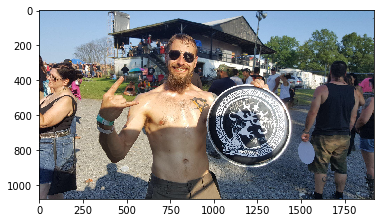

In [5]:
image_root = 'data/style/'
image_name = 'Heff'
img_fn = f'{image_root}{image_name}.jpg'
img = open_image(img_fn)
plt.imshow(img);

In [6]:
#sz=min(img.shape[:-1])
sz=1000
#sz=288

In [7]:
trn_tfms,val_tfms = tfms_from_model(vgg16, sz)
img_tfm = val_tfms(img)
img_tfm.shape

(3, 1000, 1000)

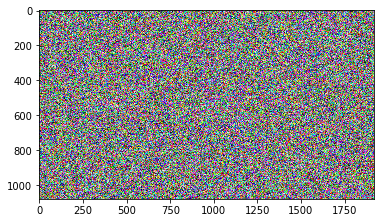

In [8]:
opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
plt.imshow(opt_img);

In [9]:
opt_img = scipy.ndimage.filters.median_filter(opt_img, [4,4,1])

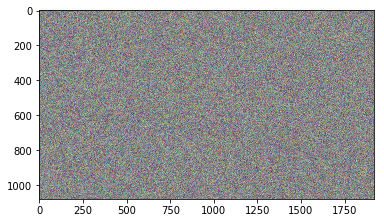

In [10]:
plt.imshow(opt_img);

In [11]:
opt_img = val_tfms(opt_img)/2
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 1000, 1000])

In [12]:
m_vgg = nn.Sequential(*children(m_vgg)[:30])

In [13]:
m_vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
  (17): Conv2d(256, 256, ke

In [14]:
targ_t = m_vgg(VV(img_tfm[None]))
targ_v = V(targ_t)
targ_t.shape

torch.Size([1, 512, 125, 125])

In [15]:
max_iter = 3000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

In [16]:
def actn_loss(x): return F.mse_loss(m_vgg(x), targ_v)*1000

In [17]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: n_iter, loss: {loss.data[0]}')
    return loss

In [18]:
n_iter=0
#while n_iter <= max_iter: optimizer.step(partial(step,actn_loss))

In [19]:
#x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
#plt.figure(figsize=(7,7))
#plt.imshow(x);

## forward hook

In [20]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [21]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

In [22]:
block_ends = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

In [23]:
sf = SaveFeatures(children(m_vgg)[block_ends[3]])

In [24]:
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v])

In [25]:
opt_img_v, optimizer = get_opt()

In [26]:
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())
targ_v.shape

torch.Size([1, 512, 125, 125])

In [27]:
def actn_loss2(x):
    m_vgg(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v)*1000

In [28]:
n_iter=0
#while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

In [29]:
#x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
#plt.figure(figsize=(7,7))
#plt.imshow(x);

In [30]:
sf.close()

## Style match

In [31]:
style_root = Path('data/style/')
style_name = 'Monet_Le_Grand_Canal'
style_fn = style_root/(style_name + '.jpg')

In [32]:
style_img = open_image(style_fn)
style_img.shape, img.shape

((1748, 2202, 3), (1080, 1920, 3))

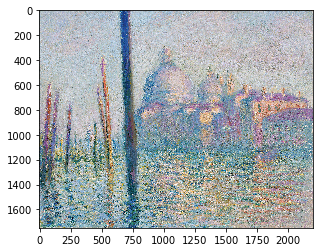

In [33]:
plt.imshow(style_img);

In [34]:
def scale_match(src, targ):
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    rat = max(h/sh,w/sw); rat
    res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [35]:
style = scale_match(img, style_img)

((1080, 1920, 3), (1080, 1920, 3))

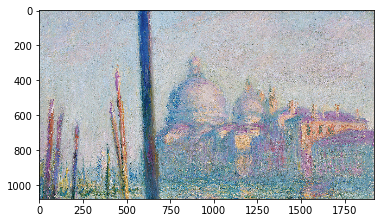

In [36]:
plt.imshow(style)
style.shape, img.shape

In [37]:
opt_img_v, optimizer = get_opt()

In [38]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [39]:
m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 1000, 1000]),
 torch.Size([1, 128, 500, 500]),
 torch.Size([1, 256, 250, 250]),
 torch.Size([1, 512, 125, 125]),
 torch.Size([1, 512, 62, 62])]

In [40]:
style_tfm = val_tfms(style_img)

In [41]:
m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 1000, 1000]),
 torch.Size([1, 128, 500, 500]),
 torch.Size([1, 256, 250, 250]),
 torch.Size([1, 512, 125, 125]),
 torch.Size([1, 512, 62, 62])]

In [42]:
def gram(input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

In [43]:
def style_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    return sum(losses)

In [44]:
#n_iter=0
#while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

In [45]:
#x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
#plt.figure(figsize=(7,7))
#plt.imshow(x);

## Style transfer

In [46]:
opt_img_v, optimizer = get_opt()

In [47]:
cnt_loss_multiplier = (sz**2)/(292**2)*2000000/2

In [48]:
def comb_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    cnt_loss   = F.mse_loss(outs[3], targ_vs[3])*cnt_loss_multiplier
    style_loss = sum(losses)
    return cnt_loss + style_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: n_iter, loss: 5798.3505859375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: n_iter, loss: 1475.0587158203125


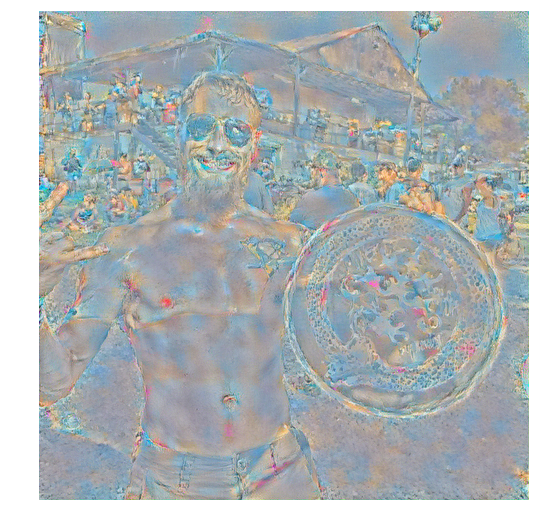

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: n_iter, loss: 1026.05078125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: n_iter, loss: 836.62841796875


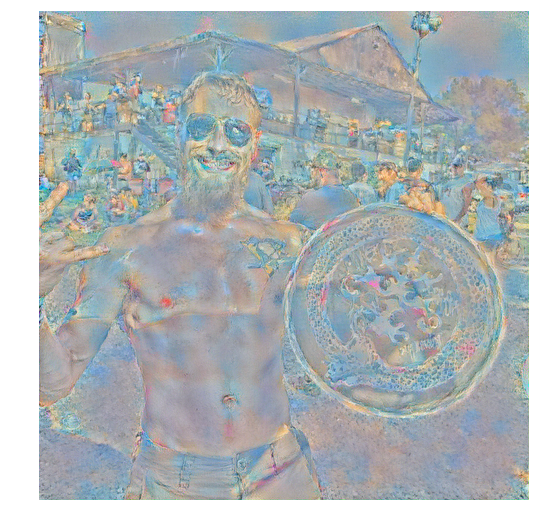

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
n_iter=0
images = []
fig, ax = plt.subplots(figsize=(9,9))
ax.axis('off')

while n_iter <= max_iter: 
    optimizer.step(partial(step,comb_loss))
    if n_iter % 5 == 0 or n_iter == 0:
        x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0] 
        x = x.clip(min=0, max=255)
        im_plt = ax.imshow(x, interpolation='lanczos')
        images.append([im_plt])
        if n_iter % 200 == 0:
            display(fig)

In [ ]:
ani = animation.ArtistAnimation(fig, images, interval=100, blit=True, repeat_delay=1000)
animation_name = style_root/(f'{style_name}_{image_name}.mp4')
print(animation_name)
ani.save(animation_name)
ani

In [ ]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(9,9))
plt.imshow(x, interpolation='lanczos')
plt.axis('off');

In [ ]:
#for sf in sfs: sf.close()